In [145]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

def minibatch(N, M):
    """Splits data set x into M roughly equally minibatches. If not evenly divisible, the excess
    is evenly spread throughout some of the batches.

    Args:
        N (Int): Number of datapoints
        M (Int): Number of minibatches

    Returns:
        Array: [M,.]-dim array containing the minibatch indices
    """
    indices = np.random.permutation(N)  # random permutation of [0, ..., len(x)-1]
    indices = np.array_split(indices, M)  # Split permutation into M sub-arrays
    return indices

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

propose a trial solution to the ODE in the form
$$ 
    f_t(t, P) = v_0 \, e^{-t} + (1-e^{-t}) N(t,P)
$$
Where $N$ denotes the Neural Network, and $P$ its free parameters.

In [146]:
def costfunction(t, N, A, trial_func):
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        N_curr = N[i].reshape(-1,1)
        v = trial_func(t[i], N_curr)
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N_curr), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v)) * torch.eye(v.size(0))).mm(v))
            
        # Increment the loss function
        loss = loss + (dfdt[:, 0] - RHS).pow(2).mean()
    
    return loss / t.size(0)

In [ ]:
torch.manual_seed(2020)
# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q 
A.requires_grad = True

In [27]:
A

tensor([[-0.0173,  0.7011, -2.4403,  0.6338,  0.3444, -2.7550],
        [ 0.7011, -3.4166,  1.1724, -0.2233, -1.4215, -0.9924],
        [-2.4403,  1.1724, -1.7178, -0.4207, -1.0524, -0.3791],
        [ 0.6338, -0.2233, -0.4207,  1.7434,  2.0975, -0.7133],
        [ 0.3444, -1.4215, -1.0524,  2.0975, -3.5050,  0.5459],
        [-2.7550, -0.9924, -0.3791, -0.7133,  0.5459, -1.8151]],
       requires_grad=True)

In [11]:
# Number of points to train on
num_points = 40

# normalized time domain for ODE
t = torch.linspace(0, 2, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
v0 = v0 / torch.norm(v0)

# Trial solution to ODE
def f_trial(t, N):
    return v0 * torch.exp(-t) + (1 - torch.exp(-t)) * N

In [13]:
# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

learning_rate = 2e-2
N_minibatches = 1#int(num_points / 12)
print(N_minibatches)

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


TOT_EPOCHS_10 = 0

loss_arr_tot_10 = np.empty(0, dtype=np.float)
epoch_arr_tot_10 = np.empty(0, dtype=np.float)

1


400: loss =  tensor(0.0630, grad_fn=<DivBackward0>)
410: loss =  tensor(0.0156, grad_fn=<DivBackward0>)
420: loss =  tensor(0.0052, grad_fn=<DivBackward0>)
430: loss =  tensor(0.0021, grad_fn=<DivBackward0>)
440: loss =  tensor(0.0010, grad_fn=<DivBackward0>)
450: loss =  tensor(0.0005, grad_fn=<DivBackward0>)
460: loss =  tensor(0.0003, grad_fn=<DivBackward0>)
470: loss =  tensor(0.0003, grad_fn=<DivBackward0>)
480: loss =  tensor(0.0002, grad_fn=<DivBackward0>)
490: loss =  tensor(0.0002, grad_fn=<DivBackward0>)


Text(0.5, 0, 'Epoch')

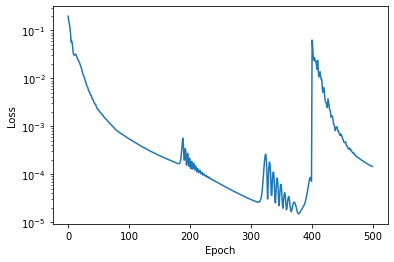

In [126]:
EPOCHS = 100

loss_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model(t[mb[i]])
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A, f_trial)
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    N_output = model(t) 
    loss = costfunction(t, N_output, A, f_trial)
    # Compute loss of entire sample
    if epoch % 10 == 0:
        print(f"{TOT_EPOCHS_10 + epoch}: loss = ",loss) 
    loss_arr_curr_10[epoch] = loss
    epoch_arr_curr_10[epoch] = TOT_EPOCHS_10 + epoch  
        
        
TOT_EPOCHS_10 += EPOCHS    
loss_arr_tot_10 = np.append(loss_arr_tot_10, loss_arr_curr_10)
epoch_arr_tot_10 = np.append(epoch_arr_tot_10, epoch_arr_curr_10)

plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")

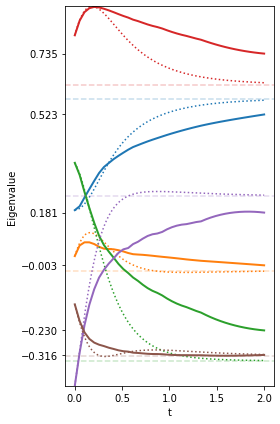

In [134]:
N_output = model(t) 
v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

# Solve ODE analytically using FW Euler
x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 200
time = np.linspace(0, dt * N, N)
x_euler = np.zeros([N, 6])

for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(4, 6))
#plt.subplot(121)

y_min = min([np.amin(x_euler), np.amin(v_pred_np)])
y_max = max([np.amax(x_euler), np.amax(v_pred_np)])

for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], ls = "solid", color=colors[d], linewidth=2)
    plt.plot(time, x_euler[:, d], ls=":" , color=colors[d], linewidth=1.5)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
#plt.yticks(x_euler[-1, :])
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min,y_max)
plt.xlabel("t")

#plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
#plt.gca().yaxis.set_label_position("right")
plt.ylabel("Eigenvalue")

"""
plt.subplot(122)
for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], "o", color=colors[d], linewidth=3)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min, y_max)
plt.xlabel("t")
"""

plt.tight_layout()
plt.savefig("test.png")
plt.show()

In [123]:
eigval, eigvec = np.linalg.eigh(A.detach().numpy())
# Compute eigenvalue
eigval_nn = (v_pred_np[-1, :].T @ A_t @ v_pred_np[-1, :] / (v_pred_np[-1, :].T @ v_pred_np[-1, :]))
print("NN Eigenvalue: %10.3f" 
      % eigval_nn)
print("Numpy Eigenvalue: %7.3f" % eigval[-1])

print("\nEigenvectors:")
print(v_pred_np[-1, :], "NN")
print(eigvec[:,-1], "Numpy")

# Note; eigvec is normed!
print("\ndot product: ", np.dot(eigvec[:, -1], v_pred_np[-1, :]))

NN Eigenvalue:      3.559
Numpy Eigenvalue:   3.722

Eigenvectors:
[ 0.4652611   0.03815136 -0.31426662  0.67312276  0.30662721 -0.36905101] NN
[ 0.57844174 -0.02141161 -0.33663774  0.6271792   0.23879324 -0.31819144] Numpy

dot product:  0.9869215397948751


## Compute the smalles eigenvalue & Eigenvector

In [147]:
A_neg = - A

In [149]:
# Number of points to train on
num_points = 40

# normalized time domain for ODE
t = torch.linspace(0, 2, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
v0 = v0 / torch.norm(v0)

# Trial solution to ODE
def f_trial_small(t, N):
    return v0 * torch.exp(-t) + (1 - torch.exp(-t)) * N

In [150]:
learning_rate = 2e-2
N_minibatches = 1#int(num_points / 12)
print(N_minibatches)

model_small = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=learning_rate)


TOT_EPOCHS_small = 0

loss_arr_tot_small = np.empty(0, dtype=np.float)
epoch_arr_tot_small = np.empty(0, dtype=np.float)

1


0: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
10: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
20: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
30: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
40: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
50: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
60: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
70: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
80: loss =  tensor(0.2280, grad_fn=<DivBackward0>)
90: loss =  tensor(0.2280, grad_fn=<DivBackward0>)


Text(0.5, 0, 'Epoch')

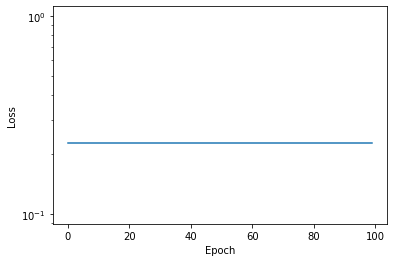

In [151]:
EPOCHS = 100

loss_arr_curr_small = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_small = np.empty(EPOCHS, dtype=np.float)

for epoch in range(EPOCHS):
    # Split into minibatches
    mb = minibatch(num_points, N_minibatches)
    
    for i in range(N_minibatches):
        N_output = model_small(t[mb[i]])
        
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A_neg, f_trial_small)
        
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    N_output = model_small(t) 
    loss = costfunction(t, N_output, A_neg, f_trial)
    
    # Compute loss of entire sample
    if epoch % 10 == 0:
        print(f"{TOT_EPOCHS_small + epoch}: loss = ",loss) 
    
    loss_arr_curr_small[epoch] = loss
    epoch_arr_curr_small[epoch] = TOT_EPOCHS_small + epoch  
        
        
TOT_EPOCHS_small += EPOCHS    
loss_arr_tot_small = np.append(loss_arr_tot_small, loss_arr_curr_small)
epoch_arr_tot_small = np.append(epoch_arr_tot_small, epoch_arr_curr_small)

plt.semilogy(epoch_arr_tot_small, loss_arr_tot_small)
plt.ylabel("Loss")
plt.xlabel("Epoch")

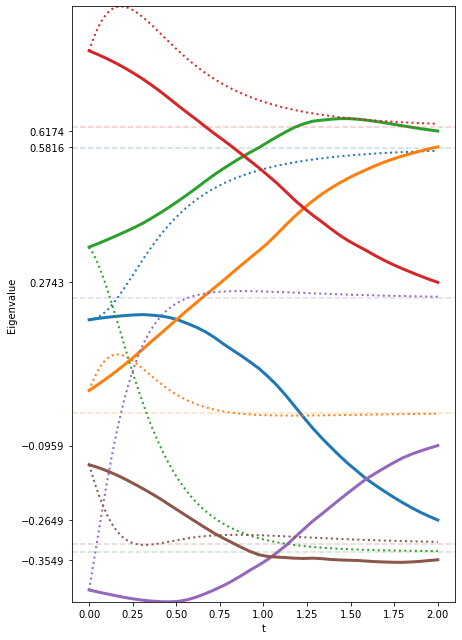

In [143]:
N_output = model_small(t) 
v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

# Solve ODE analytically using FW Euler
x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 200
time = np.linspace(0, dt * N, N)
x_euler = np.zeros([N, 6])

for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(12, 9))
plt.subplot(121)

y_min = min([np.amin(x_euler), np.amin(v_pred_np)])
y_max = max([np.amax(x_euler), np.amax(v_pred_np)])

for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], ls = "solid", color=colors[d], linewidth=3)
    plt.plot(time, x_euler[:, d], ls=":" , color=colors[d], linewidth=2)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
#plt.yticks(x_euler[-1, :])
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min,y_max)
plt.xlabel("t")

#plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
#plt.gca().yaxis.set_label_position("right")
plt.ylabel("Eigenvalue")

"""
plt.subplot(122)
for d in range(6):
    plt.plot(t.detach().numpy(), v_pred_np[:, d], "o", color=colors[d], linewidth=3)
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(v_pred_np[-1, :])
plt.ylim(y_min, y_max)
plt.xlabel("t")
"""

plt.tight_layout()
plt.savefig("test.png")
plt.show()

In [123]:
eigval, eigvec = np.linalg.eigh(A.detach().numpy())
# Compute eigenvalue
eigval_nn = (v_pred_np[-1, :].T @ A_t @ v_pred_np[-1, :] / (v_pred_np[-1, :].T @ v_pred_np[-1, :]))
print("NN Eigenvalue: %10.3f" 
      % eigval_nn)
print("Numpy Eigenvalue: %7.3f" % eigval[-1])

print("\nEigenvectors:")
print(v_pred_np[-1, :], "NN")
print(eigvec[:,-1], "Numpy")

# Note; eigvec is normed!
print("\ndot product: ", np.dot(eigvec[:, -1], v_pred_np[-1, :]))

NN Eigenvalue:      3.559
Numpy Eigenvalue:   3.722

Eigenvectors:
[ 0.4652611   0.03815136 -0.31426662  0.67312276  0.30662721 -0.36905101] NN
[ 0.57844174 -0.02141161 -0.33663774  0.6271792   0.23879324 -0.31819144] Numpy

dot product:  0.9869215397948751
